In [49]:
!pip install matplotlib
!pip install pillow

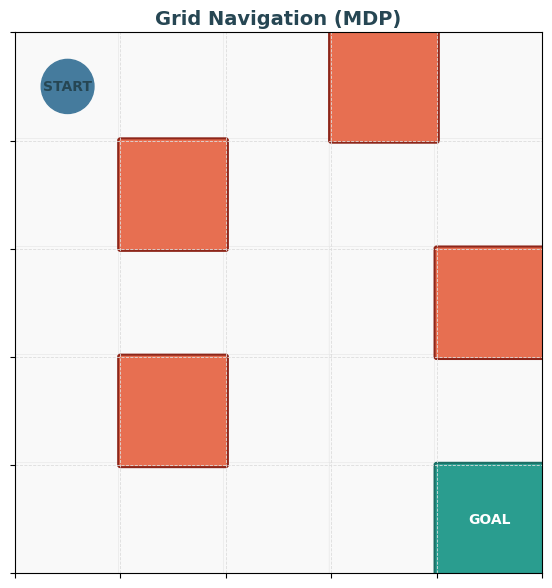

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import HTML

# Grid parameters
grid_size = 5
start_state = (0, 0)
goal_state = (4, 4)
obstacles = [(0, 3), (1, 1), (2, 4), (3, 1)]
actions = ['up', 'down', 'left', 'right']
action_effects = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

def in_bounds(state):
    x, y = state
    return 0 <= x < grid_size and 0 <= y < grid_size

def is_obstacle(state):
    return state in obstacles

# Reward function
def reward(state):
    if state == goal_state:
        return 10
    elif is_obstacle(state):
        return -10
    else:
        return -1

# Value iteration
def value_iteration(gamma=0.9, threshold=0.01):
    V = np.zeros((grid_size, grid_size))
    policy = np.full((grid_size, grid_size), '', dtype=object)

    while True:
        delta = 0
        new_V = np.copy(V)
        for x in range(grid_size):
            for y in range(grid_size):
                state = (x, y)
                if state == goal_state or is_obstacle(state):
                    continue
                values = []
                for action in actions:
                    dx, dy = action_effects[action]
                    next_state = (x + dx, y + dy)
                    if not in_bounds(next_state) or is_obstacle(next_state):
                        next_state = state
                    r = reward(next_state)
                    values.append((r + gamma * V[next_state], action))
                best_value, best_action = max(values)
                new_V[state] = best_value
                policy[state] = best_action
                delta = max(delta, abs(V[state] - best_value))
        V = new_V
        if delta < threshold:
            break
    return V, policy

# Generate path using policy
def generate_path(policy, start):
    path = [start]
    current = start
    visited = set()
    while current != goal_state:
        action = policy[current]
        if action == '' or current in visited:
            break
        visited.add(current)
        dx, dy = action_effects[action]
        next_state = (current[0] + dx, current[1] + dy)
        if not in_bounds(next_state) or is_obstacle(next_state):
            break
        path.append(next_state)
        current = next_state
    return path

# Visualization
V, policy = value_iteration()
path = generate_path(policy, start_state)

fig, ax = plt.subplots(figsize=(6, 6))
fig.subplots_adjust(top=0.92)

colors = {
    'background': '#f9f9f9',
    'grid_line': '#dddddd',
    'obstacle_fill': '#e76f51',
    'obstacle_border': '#8d261a',
    'goal_fill': '#2a9d8f',
    'goal_border': '#1b6e64',
    'start_text': '#264653',
    'trail': '#a8dadc',
    'agent': '#457b9d'
}


def draw_grid():
    ax.clear()
    ax.set_facecolor(colors['background'])
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size + 1, 1))
    ax.set_yticks(np.arange(0, grid_size + 1, 1))
    ax.grid(True, which='both', color=colors['grid_line'], linestyle='--', linewidth=0.6)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("Grid Navigation (MDP)", fontsize=14, weight='bold', color=colors['start_text'])

    for x in range(grid_size):
        for y in range(grid_size):
            rect = patches.FancyBboxPatch(
                (y, grid_size - 1 - x), 1, 1,
                boxstyle="round,pad=0.02",
                linewidth=0.3,
                edgecolor=colors['grid_line'],
                facecolor=colors['background'])
            ax.add_patch(rect)

    for (x, y) in obstacles:
        rect = patches.FancyBboxPatch((y, grid_size - 1 - x), 1, 1, boxstyle="round,pad=0.02",
                                      facecolor=colors['obstacle_fill'], edgecolor=colors['obstacle_border'], linewidth=1.5)
        ax.add_patch(rect)

    gx, gy = goal_state
    rect = patches.FancyBboxPatch((gy, grid_size - 1 - gx), 1, 1, boxstyle="round,pad=0.02",
                                  facecolor=colors['goal_fill'], edgecolor=colors['goal_border'], linewidth=1.5)
    ax.add_patch(rect)
    ax.text(gy + 0.5, grid_size - 1 - gx + 0.5, 'GOAL', ha='center', va='center', fontsize=10, color='white', weight='bold')

    sx, sy = start_state
    ax.text(sy + 0.5, grid_size - 1 - sx + 0.5, 'START', ha='center', va='center', fontsize=10, color=colors['start_text'], weight='bold')

# Animation
agent_dot = None
trail = []

def update(frame):
    global agent_dot, trail
    draw_grid()

    for i in range(frame + 1):
        x, y = path[i]
        if i < frame:
            trail_dot = plt.Circle((y + 0.5, grid_size - 1 - x + 0.5), 0.1, color=colors['trail'])
            ax.add_patch(trail_dot)
        else:
            agent_dot = plt.Circle((y + 0.5, grid_size - 1 - x + 0.5), 0.25, color=colors['agent'])
            ax.add_patch(agent_dot)

    return ax.patches

anim = animation.FuncAnimation(fig, update, frames=len(path), interval=600, repeat=False)

plt.tight_layout()
HTML(anim.to_jshtml())

In [62]:
anim.save('grid_navigation.gif', writer='pillow')